# Autre structure: CNN

### Étape 1 : Charger les données

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


In [41]:
import os 
cwd = os.getcwd()
print(cwd)

/home/onyxia/work/ml-dl-with-python/1-Quick-win/Good_Bad_queries


In [42]:


# Charger les données
def load_data(filepath, label):
    with open(filepath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        data = [(line.strip(), label) for line in lines if line.strip()]
    return data

# Emplacements des fichiers
bad_queries_path = 'badqueries.txt'
good_queries_path = 'goodqueries.txt'

# Charger et étiqueter les données
bad_data = load_data(bad_queries_path, 1)  # Étiquette 1 pour les mauvaises requêtes
good_data = load_data(good_queries_path, 0)  # Étiquette 0 pour les bonnes requêtes

# Combinez les données dans un DataFrame
all_data = pd.DataFrame(bad_data + good_data, columns=['query', 'label'])


In [43]:
# Assurez-vous d'avoir un équilibre entre les bonnes et mauvaises requêtes
sampled_bad = all_data[all_data['label'] == 1].sample(n=10000, random_state=42)
sampled_good = all_data[all_data['label'] == 0].sample(n=10000, random_state=42)

# Combine les deux échantillons en un seul DataFrame
balanced_sampled_data = pd.concat([sampled_bad, sampled_good])

# Mélangez les données pour éviter toute séquence qui pourrait influencer l'apprentissage
balanced_sampled_data = balanced_sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Affichage des nouvelles dimensions du DataFrame équilibré
print("Shape of balanced sampled data:", balanced_sampled_data.shape)


Shape of balanced sampled data: (20000, 2)




### Étape 2 : Préparation des données

Nous diviserons les données en ensembles d'entraînement et de test, puis appliquerons la vectorisation TF-IDF pour convertir les requêtes textuelles en vecteurs numériques.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(balanced_sampled_data['query'], balanced_sampled_data['label'], test_size=0.2, random_state=42)



In [45]:
# Vectorisation TF-IDF

#X_train_tfidf = vectorizer.fit_transform(X_train)
#X_test_tfidf = vectorizer.transform(X_test)

In [46]:
#vectorizer.get_feature_names_out()

## 1er modèle

In [47]:
!pip install tensorflow

Looking in indexes: https://nexus.insee.fr/repository/pypi-proxy/simple


Pour adapter `vocab_size` et `max_length` dans votre modèle CNN pour la classification de texte, voici quelques considérations et méthodes que vous pouvez utiliser :

### 1. **Déterminer `max_length`**
`max_length` est la longueur maximale d'une séquence de texte (en mots ou tokens) que votre réseau traitera. Voici comment choisir cette valeur :

- **Analyse des données** : Commencez par analyser la distribution des longueurs de vos textes. Vous pouvez le faire en calculant la longueur de chaque texte et en utilisant des statistiques descriptives ou des visualisations comme un histogramme.
- **Choix basé sur la distribution** : Souvent, on choisit une valeur qui couvre une grande partie de l'ensemble de données, par exemple, la 90ème ou 95ème percentile de la distribution des longueurs. Cela garantit que la majorité des textes sont traités sans trop de troncature tout en évitant l'effet de quelques valeurs extrêmes très longues.
  
Exemple en Python pour calculer le percentile de la longueur des textes :

In [48]:
import numpy as np

# Calcul des longueurs de texte
text_lengths = [len(text.split()) for text in X_train]

# Calcul du 95ème percentile
max_length = int(np.percentile(text_lengths, 100))

print("100% des textes ont une longueur de", max_length, "mots ou moins.")

100% des textes ont une longueur de 44 mots ou moins.


In [49]:
# Afficher les 10 premières requêtes de X_train
print(X_train.head(10))


5894                                   /gauto_motorcycle/
3728    /script/tick/allincludefortick.php?path_to_cod...
8958                         /manager/port.php?proto=tcp'
7671    /scripts/forum.php3?id_article=1&id_forum=-1/*...
5999    "%0aecho$IFSBPLBPT$((48%2B38))$(echo$IFSBPLBPT...
5751    /raanw4ia.idc?<script>cross_site_scripting.nas...
1688    /script/_conf/core/common-tpl-vars.php?confdir...
6836                                      /kaldor city 4/
6536    %2522%26%20sleep%200%20%26%26%20str%3D%24%28ec...
4842                                      /item224632185/
Name: query, dtype: object


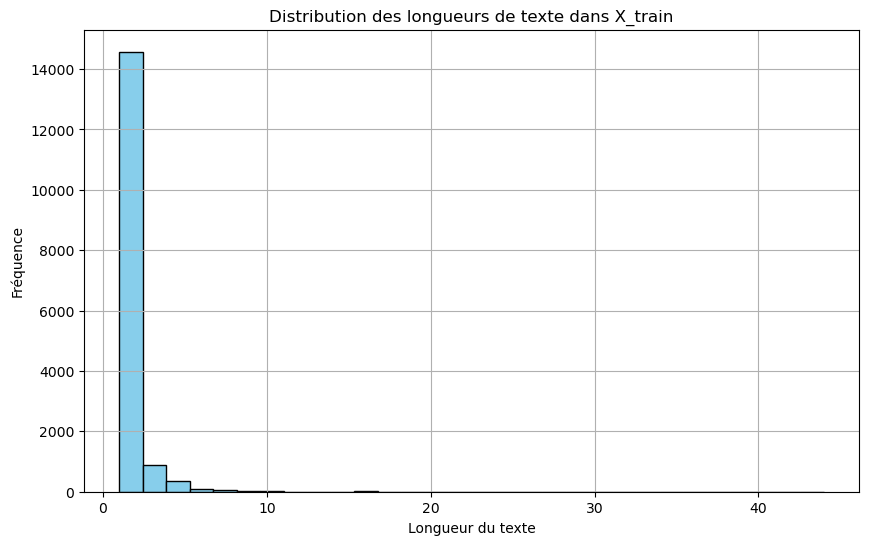

95% des textes ont une longueur de 3.0 mots ou moins.


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Calcul des longueurs de chaque texte
text_lengths = [len(text.split()) for text in X_train]

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution des longueurs de texte dans X_train')
plt.xlabel('Longueur du texte')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

# Pour calculer le 95ème percentile de ces longueurs
percentile_95 = np.percentile(text_lengths, 95)
print(f"95% des textes ont une longueur de {percentile_95} mots ou moins.")


### 2. **Déterminer `vocab_size`**
`vocab_size` est le nombre de mots uniques dans votre corpus qui seront considérés par le modèle. Voici comment le définir :

- **Calcul du vocabulaire** : Utilisez vos données d'entraînement pour déterminer combien de mots uniques existent.
- **Choix de `vocab_size`** : Vous pourriez vouloir limiter ce nombre pour réduire la complexité du modèle et éviter l'overfitting. Un choix courant est de garder seulement les mots les plus fréquents, ce qui peut être effectué en utilisant un tokenizer ou un vectoriseur qui supporte cette fonctionnalité.
- **Utilisation de Tokenizer de Keras** : Keras offre un outil pratique, `Tokenizer`, qui peut automatiquement gérer le vocabulaire et convertir les textes en séquences de mots. Vous pouvez le configurer pour utiliser uniquement les mots les plus fréquents.

Exemple en Python pour ajuster `vocab_size` :
```python



from keras.preprocessing.text import Tokenizer

# Initialisation du tokenizer avec une taille de vocabulaire limitée
tokenizer = Tokenizer(num_words=20000)  # Supposons que vous voulez garder les 20,000 mots les plus fréquents
tokenizer.fit_on_texts(X_train)

# Vous pouvez maintenant utiliser tokenizer pour convertir les textes en séquences
sequences = tokenizer.texts_to_sequences(X_train)

# Accédez au dictionnaire de mots
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')
```

Dans cet exemple, `num_words` dans `Tokenizer` contrôle la taille maximale du vocabulaire utilisé pour vectoriser les textes. Les mots au-delà de cette limite seront ignorés. Cela aide à gérer l'efficacité de la mémoire et à réduire le bruit potentiel de mots très rares dans la formation du modèle.

En résumé, la détermination de `vocab_size` et `max_length` doit être faite de manière stratégique, basée sur une analyse de vos données spécifiques. Une bonne pratique consiste à expérimenter avec différentes valeurs pour voir leur impact sur les performances du modèle.

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Étendre le vocabulaire
tokens = ['/', '<', '>', 'script', 'alert', 'http', '.exe', '.jpg', '=', 'select', 'drop', '--', '%', '..\\']

# Créer le tokenizer avec un vocabulaire plus large et configurer pour n-grams
tokenizer = Tokenizer(num_words=len(tokens), filters='', lower=False, split=' ', char_level=False, oov_token="<OOV>")
tokenizer.fit_on_texts(tokens)  # Mettre à jour l'index avec ces tokens

# Exemple de données avec des tokens potentiellement malveillants
example_data = [
    "/examples/jsp/cal/search.php?allwords=<br><script>foo</script>&cid=0&title=1&desc=1",
    "/moodle/filter/tex/texed.php?formdata=foo&pathname=foo\"+||+echo+db+4d+5a+50+00+02+00+00+00+04+00+0f+00+ff+ff+00+00+b8+00+00+00+00+00+00+00+40++>>esbq"
]

# Tokenisation et padding des séquences
sequences = tokenizer.texts_to_sequences(example_data)
data = pad_sequences(sequences, maxlen=100)

print(data)  # Affiche les séquences de données prêtes pour un modèle de réseau de neurones


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [52]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Création du tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')  # 'num_words' est le nombre max de mots à garder

# Exemple de données
example_data = [
    "/examples/jsp/cal/search.php?allwords=<br><script>foo</script>&cid=0&title=1&desc=1",
    "/moodle/filter/tex/texed.php?formdata=foo&pathname=foo\"+||+echo+db+4d+5a+50+00+02+00+00+00+04+00+0f+00+ff+ff+00+00+b8+00+00+00+00+00+00+00+40++>>esbq"
]

# Adapter le tokenizer aux données
tokenizer.fit_on_texts(example_data)
sequences = tokenizer.texts_to_sequences(example_data)
padded = pad_sequences(sequences, padding='post')  # 'post' signifie que le padding est ajouté à la fin

print("Sequences:", sequences)
print("Padded Sequences:", padded)
print("Word Index:", tokenizer.word_index)  # Affiche le dictionnaire des mots indexés


Sequences: [[8, 9, 10, 11, 4, 12, 13, 5, 3, 5, 14, 15, 16, 6, 17, 6], [18, 19, 20, 21, 4, 22, 3, 23, 3, 24, 25, 26, 27, 28, 2, 29, 2, 2, 2, 30, 2, 31, 2, 7, 7, 2, 2, 32, 2, 2, 2, 2, 2, 2, 2, 33, 34]]
Padded Sequences: [[ 8  9 10 11  4 12 13  5  3  5 14 15 16  6 17  6  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0]
 [18 19 20 21  4 22  3 23  3 24 25 26 27 28  2 29  2  2  2 30  2 31  2  7
   7  2  2 32  2  2  2  2  2  2  2 33 34]]
Word Index: {'<OOV>': 1, '00': 2, 'foo': 3, 'php': 4, 'script': 5, '1': 6, 'ff': 7, 'examples': 8, 'jsp': 9, 'cal': 10, 'search': 11, 'allwords': 12, 'br': 13, 'cid': 14, '0': 15, 'title': 16, 'desc': 17, 'moodle': 18, 'filter': 19, 'tex': 20, 'texed': 21, 'formdata': 22, 'pathname': 23, 'echo': 24, 'db': 25, '4d': 26, '5a': 27, '50': 28, '02': 29, '04': 30, '0f': 31, 'b8': 32, '40': 33, 'esbq': 34}


In [53]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Supposons que tokenizer a déjà été créé et formé

tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

# Padding des séquences pour avoir la même longueur
data = pad_sequences(sequences, maxlen=max_length)

# Définition de vocab_size basé sur le tokenizer
vocab_size = len(tokenizer.word_index) + 1  # +1 pour le token OOV si utilisé

# Définir embedding_dim, par exemple à 100
embedding_dim = 100

# Calcul ou définition de max_length, vous pouvez utiliser un percentile comme décrit précédemment
max_length = 150  # Supposons que vous avez choisi ce nombre basé sur l'analyse de la distribution des longueurs

# Modèle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [54]:
# Supposons que 'data' est votre matrice de features et 'y_train' vos labels
model.fit(data, y_train, epochs=10, batch_size=32)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8951 - loss: 0.2837
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9808 - loss: 0.0629
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9918 - loss: 0.0348
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9941 - loss: 0.0285
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9948 - loss: 0.0251
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9959 - loss: 0.0200
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9960 - loss: 0.0191
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9947 - loss: 0.0250
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9953 - loss: 0.0214
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9957 - loss: 0.0213


In [55]:
import numpy as np
import time
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Assurez-vous que 'data' et 'y_train' sont des numpy arrays
data_array = np.array(data)
y_train_array = np.array(y_train)

# Exemple de boucle de validation croisée avec les modifications
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
acc_per_fold = []
loss_per_fold = []
times_per_fold = []

for train, test in kfold.split(data_array, y_train_array):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Début du chronomètre
    start_time = time.time()

    # Entraînement
    print(f'Training for fold {fold_no} ...')
    model.fit(data_array[train], y_train_array[train], batch_size=32, epochs=10, verbose=1)

    # Évaluation du modèle
    scores = model.evaluate(data_array[test], y_train_array[test], verbose=0)

    # Fin du chronomètre
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_per_fold.append(elapsed_time)

    # Stockage des scores
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

# Affichage des résultats
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Time: {times_per_fold[i]:.2f} sec')
print('------------------------------------------------------------------------')
print(f'Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Average Time per Fold: {np.mean(times_per_fold):.2f} sec')
print('------------------------------------------------------------------------')


Training for fold 1 ...
Epoch 1/10


/opt/mamba/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.8813 - loss: 0.3112
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9798 - loss: 0.0651
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9902 - loss: 0.0319
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9945 - loss: 0.0271
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9956 - loss: 0.0214
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9951 - loss: 0.0218
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.9967 - loss: 0.0162
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9958 - loss: 0.0196
Epoch 9/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.9962 - loss: 0.0174
Epoch 10/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9964 - loss: 0.0180
Training for fold 2 ...
Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.8780 - loss: 0.3056
Epoch 2/10
400/400

Les résultats de la validation croisée que vous avez obtenus sont très encourageants. Avec une précision moyenne de 97.36% et une très faible variation (écart-type de 0.22%), votre modèle semble bien généraliser sur différentes partitions de vos données. Voici quelques points à considérer et des étapes possibles pour améliorer encore ou valider davantage votre modèle :

### Analyse des Résultats
1. **Stabilité du Modèle** : La faible variation dans les scores de précision indique que le modèle est stable à travers différents sous-ensembles de données, ce qui est un signe positif de sa capacité à généraliser.
2. **Consistance de la Perte** : La perte moyenne est également assez faible et constante à travers les plis, ce qui suggère que le modèle ne souffre pas de surapprentissage significatif.

### Étapes Suivantes
1. **Examen des Erreurs** : Analysez les cas où le modèle fait des erreurs pour voir s'il y a des patterns spécifiques ou des types de données sur lesquels il ne performe pas bien.
2. **Optimisation des Hyperparamètres** : Bien que les résultats soient déjà excellents, vous pourriez explorer l'optimisation des hyperparamètres pour voir si de légers ajustements peuvent améliorer encore les performances. Cela peut inclure l'ajustement de la taille des embeddings, la modification des tailles de filtres ou des couches dans le modèle CNN, ou l'expérimentation avec différents optimiseurs ou taux d'apprentissage.
3. **Validation Externe** : Si possible, testez le modèle sur un ensemble de données externe qui n'a pas été utilisé pendant l'entraînement ou la validation croisée pour évaluer sa robustesse dans des conditions réelles.
4. **Augmentation de Données** : Pour les tâches de traitement du texte, notamment dans le contexte de la sécurité ou des requêtes HTTP, l'augmentation des données (par exemple, par la génération synthétique de données textuelles similaires) pourrait aider à améliorer la robustesse du modèle.

### Considérations Finales
- **Interprétabilité** : Si c'est important pour votre application, envisagez des techniques pour rendre le modèle plus interprétable, comme l'analyse des poids de la couche d'embedding ou l'utilisation de techniques telles que LIME ou SHAP pour expliquer les prédictions.
- **Déploiement** : Planifiez le déploiement du modèle, ce qui peut inclure l'intégration à des systèmes existants, la surveillance de la performance en production, et l'établissement de pipelines pour la mise à jour régulière du modèle avec de nouvelles données.

Ces scores montrent que vous avez un modèle solide pour votre tâche de classification, et ces étapes vous aideront à l'optimiser et à le préparer pour un déploiement efficace.

Examiner les erreurs qu'un modèle de machine learning fait pendant le test ou la validation est crucial pour comprendre ses limites et pour identifier des pistes d'amélioration. Voici une approche en plusieurs étapes pour examiner les erreurs de votre modèle de classification de texte, en utilisant les données et les prédictions :

### 1. **Collecter les Prédictions et les Vraies Étiquettes**
D'abord, assurez-vous de collecter les prédictions de votre modèle ainsi que les vraies étiquettes des données sur lesquelles il a été testé.


In [56]:
predictions = model.predict(data[test])
predicted_labels = (predictions > 0.5).astype(int)  # Seuil de 0.5 pour la classification binaire

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


### 2. **Comparer les Prédictions aux Vraies Étiquettes**
Ensuite, comparez les prédictions aux vraies étiquettes pour identifier où le modèle se trompe.


In [57]:
incorrect_indices = np.where(predicted_labels.flatten() != y_train_array[test])[0]


In [58]:
for index in incorrect_indices:
    print(f"Text: {X_train.iloc[test[index]]}")  # Assurez-vous que c'est correct pour l'accès à X_train
    print(f"Predicted Label: {predicted_labels[index][0]}")
    print(f"True Label: {y_train_array[test[index]]}")
    print("-" * 80)


Text: <stylesheet xmlns="http://www.w3.org/TR/WD-xsl">
Predicted Label: 0
True Label: 1
--------------------------------------------------------------------------------
Text: /javascript/exe.tgz
Predicted Label: 1
True Label: 0
--------------------------------------------------------------------------------
Text: /elseif/moduleajouter/depot/usrdepot.php?corpsdesign=http://192.168.202.96:8080/llumt7msyau5y?
Predicted Label: 1
True Label: 0
--------------------------------------------------------------------------------
Text: /examples/jsp/sessions/siteframe.php?local_path=macros/100-siteframe.macro\x00
Predicted Label: 1
True Label: 0
--------------------------------------------------------------------------------
Text: /destiny's_child/
Predicted Label: 0
True Label: 1
--------------------------------------------------------------------------------
Text: /help.php?q=del\xa0q27113942&rem\xa0
Predicted Label: 1
True Label: 0
---------------------------------------------------------------

### 3. **Analyse des Erreurs**
Pour chaque instance mal classifiée, examinez le texte, la prédiction du modèle, et la vraie étiquette. Cela peut vous aider à identifier des patterns ou des types de textes spécifiques pour lesquels le modèle ne performe pas bien.

In [59]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous d'avoir `y_train_array` disponible comme numpy array
true_labels = y_train_array[test]  # Utilisez les vraies étiquettes pour l'ensemble de test
cm = confusion_matrix(true_labels, predicted_labels.flatten())


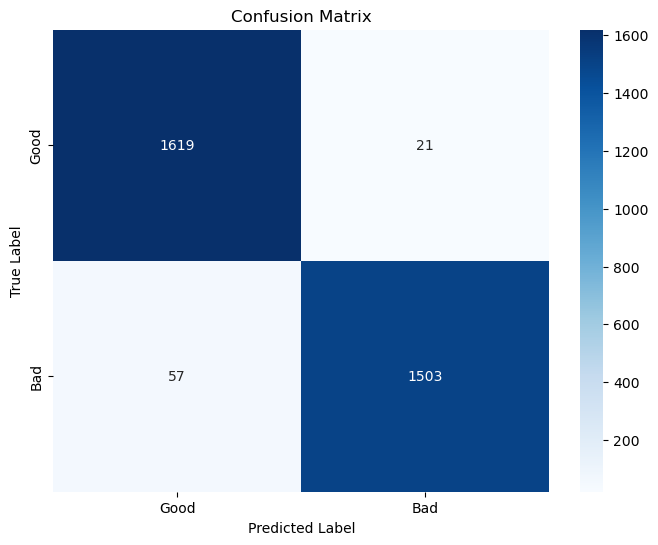

In [60]:
# Configuration pour une meilleure visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Pour identifier spécifiquement les instances où le modèle a prédit à tort des valeurs positives (dans votre cas, classifiant à tort des requêtes comme "bonnes" alors qu'elles étaient en réalité des "mauvaises requêtes"), vous pouvez suivre les étapes suivantes pour isoler ces cas et les examiner plus en détail. 

#### 1. **Obtenir les Indices des Erreurs de Type I (Faux Positifs)**
Vous pouvez calculer les faux positifs en comparant les étiquettes prédites avec les vraies étiquettes. Utilisez les indices pour localiser les erreurs dans vos données.


In [61]:
import numpy as np

# predictions a déjà été généré par model.predict(data[test])
predicted_labels = (predictions > 0.5).astype(int)  # Assurez-vous que cela est adapté à votre seuil

# Assurez-vous d'avoir `y_train_array` comme numpy array
true_labels = y_train_array[test]  # Utilisez les vraies étiquettes de l'ensemble de test

# Trouver les indices des faux positifs
false_positives = np.where((predicted_labels.flatten() == 1) & (true_labels == 0))[0]

#### 2. **Extraire les Requêtes Correspondantes**
Avec les indices des faux positifs, vous pouvez extraire les requêtes HTTP correspondantes de votre ensemble de test pour les examiner. Cela nécessite que `X_train` ou l'ensemble de données original soit accessible et correctement aligné avec `data[test]`.

In [62]:
# Assurez-vous que X_train est accessible et que son indexation est correcte
false_positive_texts = X_train.iloc[test[false_positives]]  # Utilisez iloc si X_train est un DataFrame

# Afficher les textes mal classifiés
print("Faux Positifs (Good requests prises pour des Bad requests) :")
for i, text in enumerate(false_positive_texts):
    print(f"{i + 1}: {text}")

Faux Positifs (Good requests prises pour des Bad requests) :
1: /javascript/exe.tgz
2: /elseif/moduleajouter/depot/usrdepot.php?corpsdesign=http://192.168.202.96:8080/llumt7msyau5y?
3: /examples/jsp/sessions/siteframe.php?local_path=macros/100-siteframe.macro\x00
4: /help.php?q=del\xa0q27113942&rem\xa0
5: /adobedocumentservicessec/config/bindings?wsdl&style=http
6: /_administration/securite.php?cfg[document_uri]=http://192.168.202.96:8080/swgnhpydbq0t?
7: /tiki-login_scr/
8: /060911-xp_restore/
9: /top.php?stuff=ping,-w,11000,-n,1,4.3.2.1|rem,
10: /help.php?q=ping\x0c-w\x0c7000\x0c-n\x0c1\x0c4.3.2.1|rem\x0c
11: /keygen/
12: /cgi-bin/spt--forumtopics.php?forumid=-9 union select null,null,null,1332008335,4,5
13: /top-10/
14: /phpmyadmin/new_images.php?order=linpha_order_sql_injection.nasl_1332008613
15: /dovez - the second wave shared by mr/
16: /examples/jsp/checkbox/index.php?action=logout&sesc=1
17: /main.php?logout=&del,q27276952&rem,
18: /head_14/
19: /dragonball gt 1-9/
20: /me-kom


#### 3. **Analyse des Textes Faux Positifs**
Une fois que vous avez identifié les requêtes mal classifiées, vous pouvez :

- **Revoir le Contenu** : Examinez le contenu des requêtes pour identifier des caractéristiques communes ou des motifs qui pourraient avoir trompé le modèle.
- **Considérer le Contexte** : Pensez au contexte ou à la structure spécifique des requêtes qui pourrait être mal interprétée par le modèle.

#### 4. **Amélioration du Modèle**
En fonction de vos observations, vous pourriez envisager des ajustements tels que :

- **Amélioration de la Préparation des Données** : Ajoutez un nettoyage plus spécifique ou des transformations pour mieux capter les caractéristiques des "bad requests".
- **Entraînement Supplémentaire** : Entraînez le modèle avec plus de données, en particulier en augmentant les exemples de "bad requests" similaires à ceux mal classifiés.
- **Ajustement de l'Architecture du Modèle** : Modifiez le modèle pour mieux capturer les caractéristiques pertinentes, ou ajoutez des couches de régularisation si le modèle surajuste certaines caractéristiques non pertinentes.

En suivant ces étapes, vous pourrez non seulement identifier les erreurs spécifiques de votre modèle mais également prendre des mesures informées pour améliorer sa performance générale.

Pour identifier spécifiquement les instances où votre modèle a prédit incorrectement des valeurs négatives alors qu'elles étaient positives (dans votre contexte, cela signifierait que des "bad requests" ont été faussement classifiées comme "good requests"), vous pouvez suivre une approche similaire à celle utilisée pour les faux positifs mais inverser la logique pour détecter les faux négatifs.

### Étapes pour identifier les faux négatifs:

1. **Calcul des Faux Négatifs**:
   Utilisez les prédictions et les vraies étiquettes pour identifier où le modèle a prédit '0' (négatif) alors que la vraie étiquette était '1' (positif).

2. **Extraire les Textes Correspondants**:
   Utilisez les indices obtenus pour extraire les requêtes correspondantes de votre ensemble de données.

### Code pour les faux négatifs:

Assurez-vous que `predictions`, `y_train_array`, et `test` sont définis comme expliqué précédemment.


In [63]:
import numpy as np

# Prédiction à partir du modèle, assurez-vous que cela est déjà fait
predicted_labels = (predictions > 0.5).astype(int)  # Appliquer un seuil de 0.5 pour la classification binaire

# Calculer les indices des faux négatifs
false_negatives = np.where((predicted_labels.flatten() == 0) & (y_train_array[test] == 1))[0]

# Supposons que X_train est un DataFrame Pandas accessible et que les indices sont alignés
# Si X_train est sous forme de numpy array ou list, assurez-vous d'utiliser la méthode d'accès correcte
false_negative_texts = X_train.iloc[test[false_negatives]]

# Afficher les textes mal classifiés
print("Faux Négatifs (Bad requests classifiées comme Good) :")
for i, text in enumerate(false_negative_texts):
    print(f"{i + 1}: {text}")

Faux Négatifs (Bad requests classifiées comme Good) :
1: <stylesheet xmlns="http://www.w3.org/TR/WD-xsl">
2: /destiny's_child/
3: /cgi-bin/../abyss.conf
4: --><!--*{color:red}   /* all UA */
5: /boobsquad - daddy's girl gets stuffed/
6: <button data=popup=1; id='x'onfocus=popup=1; >
7: /cgi-bin/remindpasswd
8: /subscriptionforms/
9: <![C b="c">
10: ..%25%35%63
11: truncate
12: /meijer01scripting/
13: <%00/title>
14: /a_hrefhttpw3bmttuenlnlmensenbmtscriptpubinsectionphppublicationsa/
15: /frogger's/
16: /saviotranscript/
17: /baldur's/
18: \00
19: /order/login.php?svr_rootscript=http://192.168.202.118:8080/ghl9il?
20: \0
21: /id;1089332511;fp;2;fpid;37/
22: </xsl:stylesheet>
23: /ttxssh2_107/
24: <HTML><BODY>
25: /2004conferencedescription/
26: &#000062
27: /swingin' thing-keep on swingin' (2005)/
28: /subscriptiont1/
29: /17-doin' time/
30: /scripta/
31: </feImage>
32: /matrixssl/
33: /rmscript/
34: /oldtranscripts/
35: hi or 1=1 --"
36: /382-publishersdescription/
37: /scripteditor/
3


#### Explications:
- **`np.where()`**: Cette fonction est utilisée pour trouver les indices des éléments qui satisfont la condition spécifiée, ici étant les cas où les prédictions ne correspondent pas aux étiquettes attendues et où les vraies étiquettes sont positives ('1').
- **`predicted_labels.flatten()`**: Assure que le tableau de prédictions est une dimension pour correspondre avec le tableau de vraies étiquettes.
- **`X_train.iloc[test[false_negatives]]`**: Extrayez les textes spécifiques de `X_train` qui correspondent aux indices des faux négatifs. Assurez-vous que l'indexation de `X_train` est correctement configurée pour cela.

Cette approche vous permettra d'examiner les cas où des requêtes malicieuses ou incorrectes (bad requests) ont été incorrectement classifiées comme légitimes (good requests), vous aidant ainsi à identifier les lacunes potentielles dans le modèle ou les données qui nécessitent une attention particulière.

 Ces faux négatifs sont des erreurs critiques, surtout dans le contexte de la sécurité des systèmes, car ils représentent des menaces potentielles qui ne sont pas identifiées.

### Analyse des Faux Négatifs
Les exemples montrent une variété de patterns typiques des attaques ou des tentatives de manipulation, telles que :
- Injections SQL ou de commandes (`rm`, `del`).
- Utilisation de caractères spéciaux et d'encodages pour masquer des tentatives malveillantes (`%00`, `../`, `</`).
- Noms qui suggèrent des tentatives d'accès à des ressources sensibles ou des scripts (`script`, `transcript`, `ini`).

### Étapes pour améliorer la détection
1. **Amélioration de la Tokenisation** :
   - Revisez votre `custom_tokenizer` pour vous assurer qu'il capture efficacement les éléments importants qui indiquent des requêtes malveillantes. Par exemple, vous voudrez peut-être capturer des séquences de caractères spécifiques qui apparaissent souvent dans les attaques.


In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Étendre le vocabulaire
tokens = ['/', '<', '>', 'script', 'alert', 'http', '.exe', '.jpg', '=', 'select', 'drop', '--', '%', '..\\']

# Créer le tokenizer avec un vocabulaire plus large et configurer pour n-grams
tokenizer = Tokenizer(num_words=len(tokens), filters='', lower=False, split=' ', char_level=False, oov_token="<OOV>")
tokenizer.fit_on_texts(tokens)  # Mettre à jour l'index avec ces tokens

# Exemple de données avec des tokens potentiellement malveillants
example_data = [
    "/examples/jsp/cal/search.php?allwords=<br><script>foo</script>&cid=0&title=1&desc=1",
    "/moodle/filter/tex/texed.php?formdata=foo&pathname=foo\"+||+echo+db+4d+5a+50+00+02+00+00+00+04+00+0f+00+ff+ff+00+00+b8+00+00+00+00+00+00+00+40++>>esbq"
]

# Tokenisation et padding des séquences
sequences = tokenizer.texts_to_sequences(example_data)
data = pad_sequences(sequences, maxlen=100)

print(data)  # Affiche les séquences de données prêtes pour un modèle de réseau de neurones


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


2. **Enrichissement des Données** :
   - Si possible, enrichissez votre ensemble de données avec plus d'exemples de ce type de requêtes malveillantes, surtout ceux qui sont mal classifiés.
   - Utilisez des techniques d'augmentation de données pour créer de nouvelles instances d'entraînement basées sur les modèles trouvés dans les faux négatifs.


NON FAIT

3. **Réévaluation des Features** :
   - Examinez les caractéristiques (features) extraites par le `TfidfVectorizer` et considérez l'ajustement des paramètres comme `ngram_range` pour capturer des motifs plus larges ou plus complexes.
   - Envisagez l'utilisation d'embeddings de mots plus sophistiqués qui pourraient capturer le contexte mieux que les simples TF-IDF.
  

NON FAIT

4. **Réglage du Modèle** :
   - Ajustez les seuils de classification pour le modèle afin de réduire le taux de faux négatifs, ce qui peut être particulièrement important si éviter les mauvaises classifications est plus critique que de capturer chaque bonne requête.
   - Testez différentes architectures de modèle ou introduisez des techniques comme le bagging ou le boosting pour voir si cela améliore la robustesse du modèle.

5. **Utilisation de Techniques de Détection Anomale** :
   - Pour les requêtes qui ne s'inscrivent pas clairement dans les patterns normaux mais qui sont également difficiles à classer directement comme malveillantes, envisagez des techniques de détection d'anomalies.

Ces étapes devraient aider à améliorer la capacité de votre modèle à identifier correctement les mauvaises requêtes, en réduisant le nombre de faux négatifs et en augmentant la sécurité globale du système que vous cherchez à protéger.

### 4. **Analyse Qualitative et Quantitative**
- **Qualitative** : Lisez les textes que le modèle a mal classifiés pour voir s'il y a des caractéristiques communes, comme des erreurs d'orthographe, des abréviations, des structures grammaticales complexes, etc.
- **Quantitative** : Analysez statistiquement les types d'erreurs. Par exemple, regardez si certaines classes sont plus sujettes aux erreurs ou si certains types de requêtes sont systématiquement mal classés.

### 5. **Visualisation des Erreurs**
Utiliser des visualisations comme des matrices de confusion pour mieux comprendre les types d'erreurs (par exemple, quelle classe est souvent confondue avec quelle autre) :


### 6. **Feedback Loop**
Utilisez ces informations pour affiner votre modèle. Cela peut impliquer l'ajustement de la préparation des données, la modification des paramètres du modèle, ou même la reformulation de la façon dont les données sont présentées au modèle.

L'examen des erreurs est un processus continu qui peut nécessiter plusieurs itérations pour isoler et résoudre les problèmes sous-jacents. C'est aussi une excellente opportunité pour découvrir des améliorations potentielles non seulement dans le modèle, mais aussi dans la collecte ou le traitement des données.

### Comparaison des résultats selon le Tokenizer

Le modèle 1 dans good_bad_CNN.ipynb :

Le Tokenizer amélioré ici:

Excellents résultats! Vous observez une amélioration avec votre tokenizer optimisé, montrant une précision élevée et stable à travers les différents plis de la validation croisée. Pour explorer encore plus loin et améliorer la robustesse et la performance de votre modèle, vous pouvez en effet envisager d'expérimenter avec différentes architectures et d'introduire des techniques d'ensemble comme le bagging ou le boosting. Voici comment vous pourriez procéder :

### 1. **Tester Différentes Architectures de Modèle**

Vous pouvez expérimenter avec différentes configurations pour les couches de votre réseau neuronal, telles que :

- **Augmenter le nombre de filtres dans les couches convolutives** : Plus de filtres peuvent permettre de capturer plus de caractéristiques fines du texte.
- **Ajouter des couches convolutives** : Empiler plusieurs couches convolutives peut aider à apprendre des hiérarchies plus complexes de caractéristiques.
- **Utiliser des tailles de noyau différentes** : Utiliser simultanément différentes tailles de noyaux dans les couches convolutives peut capter des motifs de différentes tailles dans les données.
- **Inclure des couches de dropout** : Pour prévenir le surapprentissage en désactivant aléatoirement des neurones pendant l'entraînement.

### 2. **Techniques d'Ensemble**

- **Bagging** : Le bagging implique l'entraînement de multiples modèles (généralement du même type) sur différents sous-ensembles de l'ensemble de données d'entraînement et ensuite d'agréger leurs prédictions. Vous pouvez utiliser des variantes de votre modèle CNN avec différentes initialisations ou architectures et les combiner.
  
- **Boosting** : Techniques comme AdaBoost ou Gradient Boosting peuvent être utilisées mais sont moins communes pour les réseaux de neurones. Cependant, vous pouvez expérimenter avec des bibliothèques qui supportent ces méthodes adaptées aux réseaux de neurones, telles que CatBoost ou LightGBM pour des tâches de classification de features extraits.

### 3. **Exemple d'Architecture avec Dropout et Plusieurs Couches Convolutives**

Voici un exemple d'architecture plus complexe :

```python
from tensorflow.keras.layers import Dropout

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Conv1D(filters=128, kernel_size=4, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```

### 4. **Ajustement de l'Entraînement**

En ajoutant des couches ou en modifiant l'architecture, il peut être nécessaire de revoir les paramètres d'entraînement tels que le taux d'apprentissage, le nombre d'époques, ou les tailles des lots.

### 5. **Validation**

Après avoir modifié l'architecture ou utilisé des techniques d'ensemble, il est crucial de réévaluer le modèle sur vos données de validation ou via la validation croisée pour s'assurer que les modifications apportent des améliorations significatives et ne conduisent pas à un surapprentissage.

En résumé, expérimenter avec ces techniques peut potentiellement améliorer la robustesse de votre modèle et mieux généraliser sur de nouvelles données. Chaque modification doit être soigneusement validée pour évaluer son impact réel sur la performance du modèle.